<a href="https://colab.research.google.com/github/Isabellitankian/FIAP---2023/blob/main/Clusterizacao_ImdbMovies_PyCaret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clusterizacao - Case ImdbMovies

# IMDb TOP 250 Movies
![An image](https://static.amazon.jobs/teams/53/images/IMDb_Header_Page.jpg?1501027252)

**Este projeto consiste em treinar um sistema de recomendação de filmes utilizando as informações referentes aos top 250 filmes melhor avaliados pelo público na plataforma IMDb.**
*   A extração dos dados será feita por técnicas de web scraping (crawler).
*   O objetivo principal será agrupar os 250 filmes em "n" clusters classificados a partir das suas sinopses, aplicando técnicas de processamento de texto e algoritmos de clusterização.
*   Ao final, teremos um sistemas de recomendação baseado na similaridade das sinopses, e não apenas dos generos.

**Exemplo de aplicação prática: usuários receberão recomendações de filmes que estejam no mesmo cluster de sinopses de outros filmes que ele já tenha curtido.**

# Import das bibliotecas

In [ ]:
!pip install pycaret==3.0.2

In [ ]:
import pandas as pd
import numpy as np
import requests
#from pprint import pprint
#from bs4 import BeautifulSoup
#import re
#import json
#from urllib.request import Request, urlopen
#from lxml import html
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from pycaret.clustering import *

## DataFrame

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#EDA - Exploratory Data Analysis

In [ ]:
path_to_export = '/content/drive/MyDrive/Automated_ML_and_Deploy/Aula_20230825_Clusterizacao_PyCaret'
df = pd.read_csv(f'{path_to_export}/all_movies.csv', sep = ';')

print(df.shape)
df.head()

(250, 6)


title_pt                     title_en  year  rating  \
0                          Barbie                       Barbie  2023     7.4   
1           Um Sonho de Liberdade  1. The Shawshank Redemption  1994     9.3   
2               O Poderoso Chefão             2. The Godfather  1972     9.2   
3  Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008     9.0   
4            O Poderoso Chefão II     4. The Godfather Part II  1974     9.0   

      genre                                            sinopse  
0  Aventura  Viver na Terra da Barbie é ser um ser perfeito...  
1     Drama  Dois homens presos se reúnem ao longo de vário...  
2  Policial  O patriarca idoso de uma dinastia do crime org...  
3      Ação  Quando a ameaça conhecida como O Coringa surge...  
4  Policial  Em 1950, Michael Corleone, agora à frente da f...

In [ ]:
# Adjusting variable types
df['year'] = df['year'].astype('int64')
df['rating'] = df['rating'].astype('float64')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title_pt  250 non-null    object 
 1   title_en  250 non-null    object 
 2   year      250 non-null    int64  
 3   rating    250 non-null    float64
 4   genre     250 non-null    object 
 5   sinopse   250 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 11.8+ KB


In [ ]:
df.describe()

year      rating
count   250.000000  250.000000
mean   1986.684000    8.302800
std      25.508171    0.239545
min    1921.000000    7.400000
25%    1966.000000    8.100000
50%    1994.000000    8.200000
75%    2007.000000    8.400000
max    2023.000000    9.300000

## Plots

In [ ]:
df.genre.value_counts('d')

Drama         0.276
Ação          0.180
Policial      0.140
Animação      0.096
Biografia     0.092
Comédia       0.092
Aventura      0.084
Terror        0.016
Mistério      0.016
Faroeste      0.004
Filme noir    0.004
Name: genre, dtype: float64

In [ ]:
fig = px.bar(df.genre.value_counts('d')*100,
             text_auto=True,
             title = '% de Filmes por Gênero',
             labels={'index':'Gênero',
                     'value':'% de Filmes'})
fig.show()

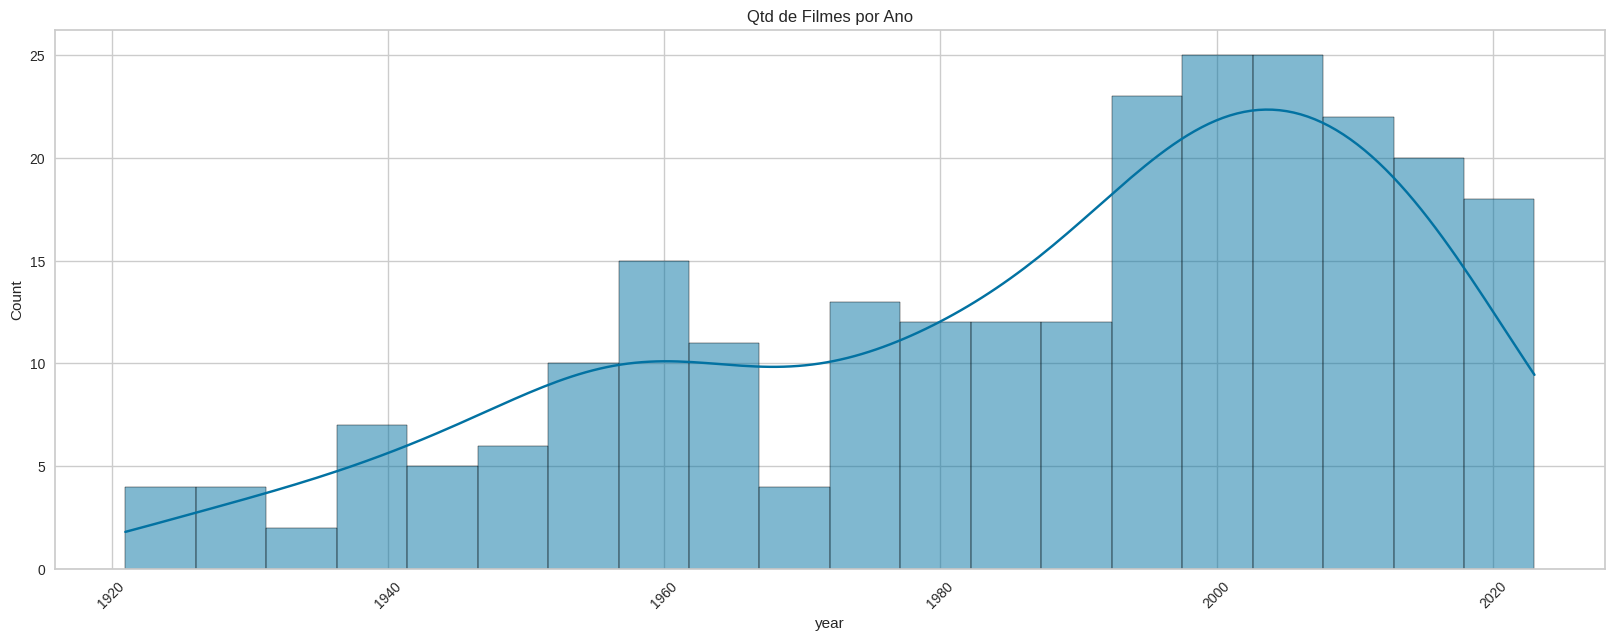

In [ ]:
plt.figure(figsize = (20,7))
sns.histplot( df,
              x = 'year',
              kde = True, bins = 20).set_title('Qtd de Filmes por Ano')
plt.xticks(rotation=45)
plt.show()

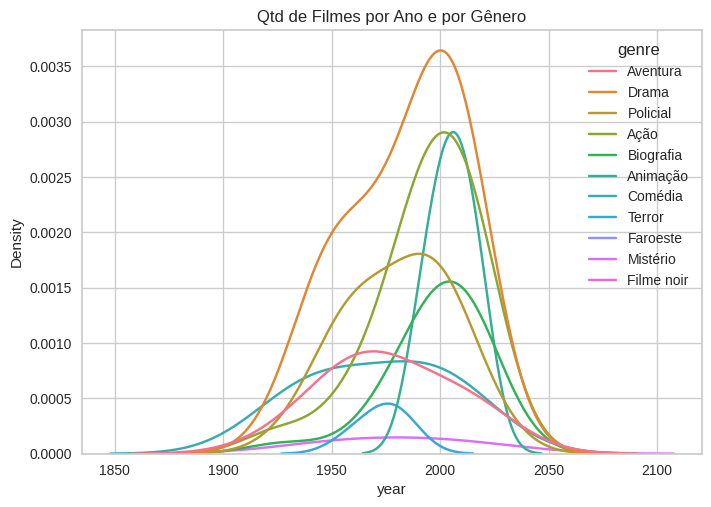

In [ ]:
sns.kdeplot( df, x = 'year', hue = 'genre', bw_adjust = 1.5, warn_singular = False).set_title('Qtd de Filmes por Ano e por Gênero')
plt.show()

# Pré-processamento de texto

In [ ]:
#convert sinopses to lowercase
df_processed = df.copy()
df_processed['sinopse'] = df_processed['sinopse'].str.lower()
df_processed['sinopse'].head()

0    viver na terra da barbie é ser um ser perfeito...
1    dois homens presos se reúnem ao longo de vário...
2    o patriarca idoso de uma dinastia do crime org...
3    quando a ameaça conhecida como o coringa surge...
4    em 1950, michael corleone, agora à frente da f...
Name: sinopse, dtype: object

In [ ]:
def qty_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [ ]:
### Feature Engineering
df_processed['word_count'] = df_processed['sinopse'].apply(qty_words).astype('int64')
df_processed.head()

title_pt                     title_en  year  rating  \
0                          Barbie                       Barbie  2023     7.4   
1           Um Sonho de Liberdade  1. The Shawshank Redemption  1994     9.3   
2               O Poderoso Chefão             2. The Godfather  1972     9.2   
3  Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008     9.0   
4            O Poderoso Chefão II     4. The Godfather Part II  1974     9.0   

      genre                                            sinopse  word_count  
0  Aventura  viver na terra da barbie é ser um ser perfeito...          29  
1     Drama  dois homens presos se reúnem ao longo de vário...          21  
2  Policial  o patriarca idoso de uma dinastia do crime org...          20  
3      Ação  quando a ameaça conhecida como o coringa surge...          33  
4  Policial  em 1950, michael corleone, agora à frente da f...          41

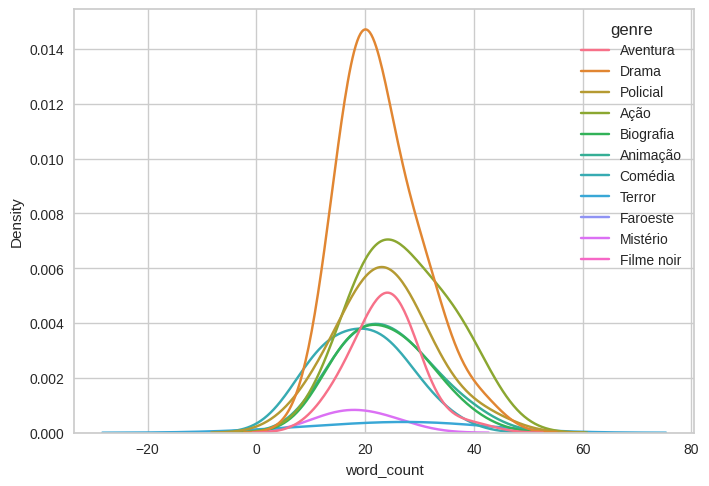

In [ ]:
sns.kdeplot( df_processed, x = 'word_count', hue = 'genre', bw_adjust = 1.5, warn_singular = False)
plt.show()

## Nuvem de palavras

### Antes de remover as stopwords

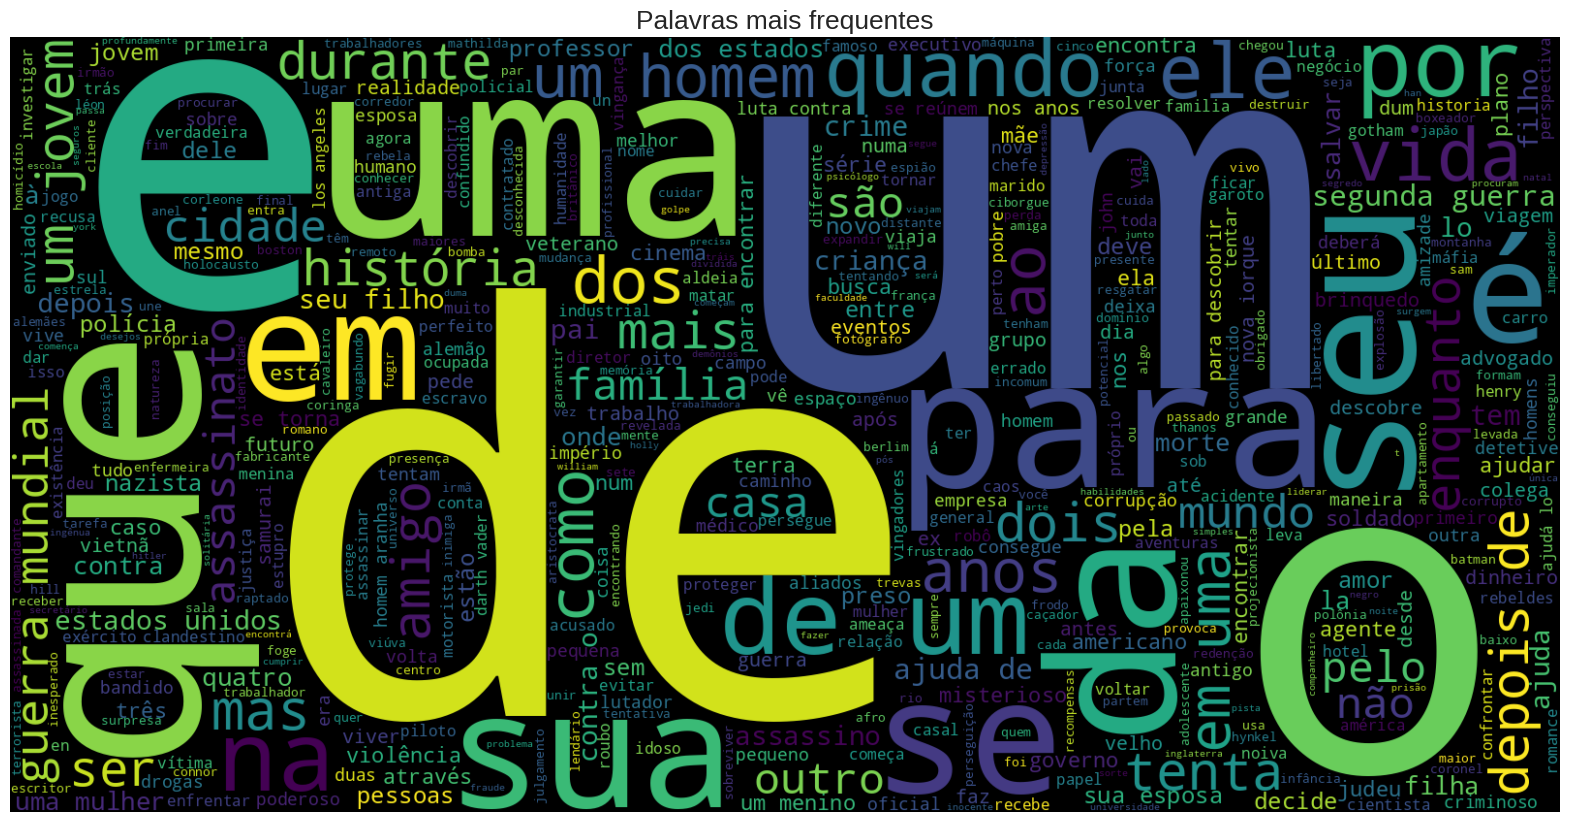

In [ ]:
text = ' '.join([phrase for phrase in df_processed['sinopse']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes', fontsize = 19)
plt.show()

### Após remoção das stopwords

In [ ]:
import nltk
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('portuguese')
print(stopwords)

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


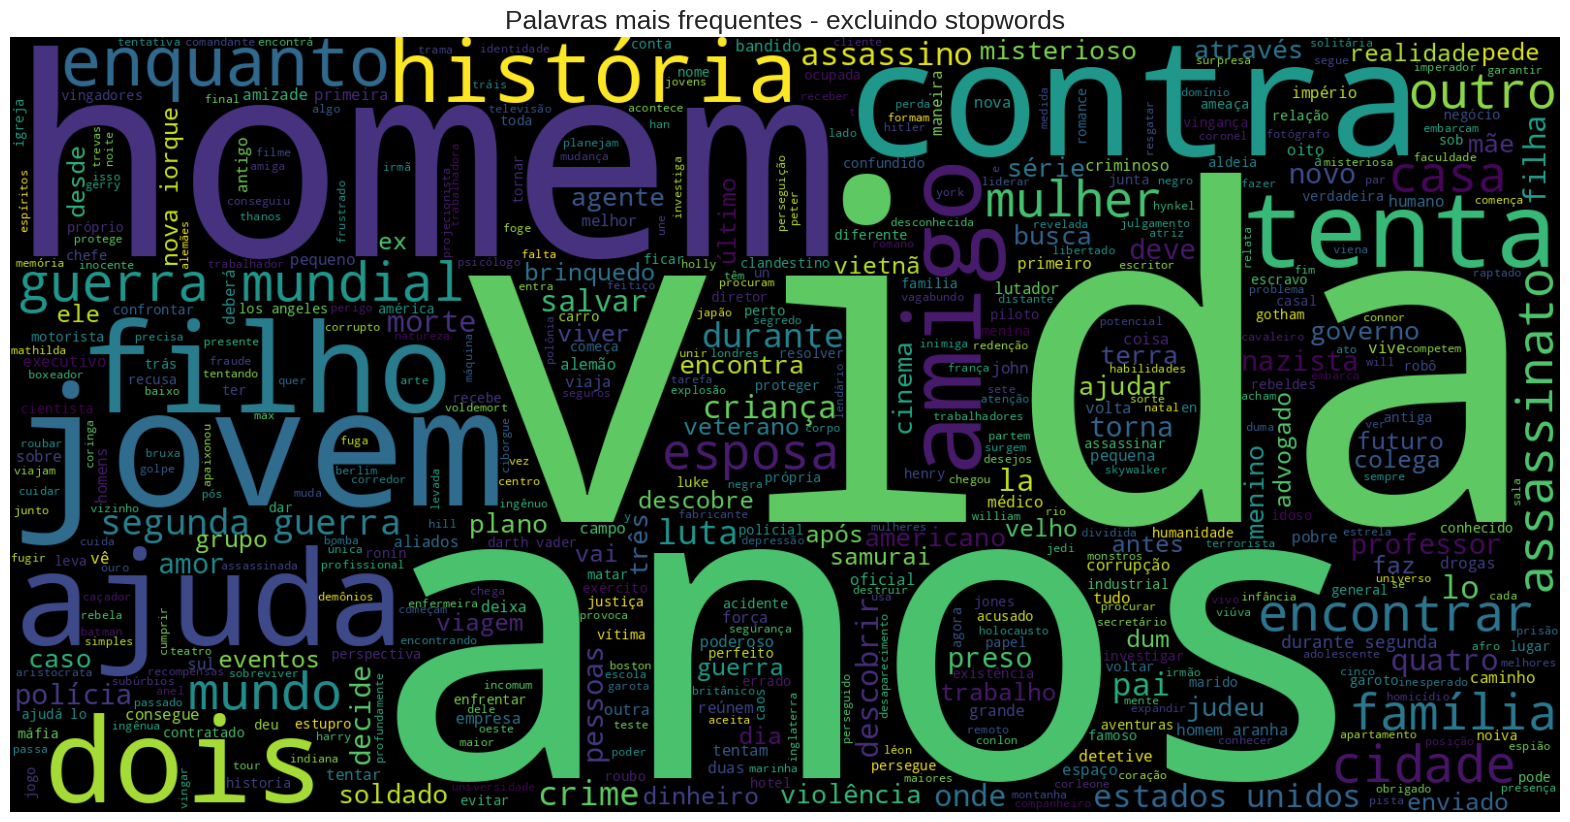

In [ ]:
df_processed['sinopse_no_stopwords'] = df_processed['sinopse'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
text = ' '.join([phrase for phrase in df_processed['sinopse_no_stopwords']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes - excluindo stopwords', fontsize = 19)
plt.show()

## Aplicando TF-IDF
Term Frequency-Inverse Document Frequency

O TF-IDF define a importância de um termo levando em consideração a importância desse termo em um único documento e dimensionando-o por sua importância em todos os documentos.

In [ ]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df_processed['sinopse_no_stopwords'])

In [ ]:
print(X.shape)
X.toarray()

(250, 82)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.70710678],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# AutoML | PyCaret - Clustering

## Setup

In [ ]:
s = setup(data = X.toarray(),
          session_id = 123)

# Create Model

In [ ]:
mdl_kmeans = create_model('kmeans')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
mdl_dbscan = create_model('dbscan')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
mdl_meanshift = create_model('meanshift')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

# Assign Model

In [ ]:
df_kmeans = assign_model(mdl_kmeans)
display(df_kmeans.Cluster.value_counts())
df_kmeans

Cluster 1    176
Cluster 2     33
Cluster 0     22
Cluster 3     19
Name: Cluster, dtype: int64

feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0          0.0        0.0        0.0        0.0        0.0        0.0   
1          0.0        0.0        0.0        0.0        0.0        0.0   
2          0.0        0.0        0.0        0.0        0.0        0.0   
3          0.0        0.0        0.0        0.0        0.0        0.0   
4          0.0        0.0        0.0        0.0        0.0        0.0   
..         ...        ...        ...        ...        ...        ...   
245        0.0        0.0        0.0        0.0        0.0        0.0   
246        0.0        0.0        0.0        0.0        0.0        0.0   
247        0.0        0.0        0.0        0.0        0.0        0.0   
248        0.0        0.0        0.0        0.0        0.0        0.0   
249        0.0        0.0        0.0        0.0        0.0        0.0   

     feature_7  feature_8  feature_9  feature_10  ...  feature_74  feature_75  \
0     0.000000        0.0        0.0         0.0  ...         0.0         0.0   
1     0.499298        0.0        0.0         0.0  ...         0.0         0.0   
2     0.000000        0.0        0.0         0.0  ...         0.0         0.0   
3     0.000000        0.0        0.0         0.0  ...         0.0         0.0   
4     0.000000        0.0        0.0         0.0  ...         0.0         0.0   
..         ...        ...        ...         ...  ...         ...         ...   
245   0.376643        0.0        0.0         0.0  ...         0.0         0.0   
246   0.000000        0.0        0.0         0.0  ...         0.0         0.0   
247   0.000000        0.0        0.0         0.0  ...         0.0         0.0   
248   0.000000        0.0        0.0         0.0  ...         0.0         0.0   
249   0.000000        0.0        0.0         0.0  ...         0.0         0.0   

     feature_76  feature_77  feature_78  feature_79  feature_80  feature_81  \
0           0.0    0.000000         0.0         0.0         0.0         0.0   
1           0.0    0.000000         0.0         0.0         0.0         0.0   
2           0.0    0.000000         0.0         0.0         0.0         0.0   
3           0.0    0.000000         0.0         0.0         0.0         0.0   
4           0.0    0.000000         0.0         0.0         0.0         0.0   
..          ...         ...         ...         ...         ...         ...   
245         0.0    0.469184         0.0         0.0         0.0         0.0   
246         0.0    0.000000         0.0         0.0         0.0         0.0   
247         0.0    0.000000         0.0         1.0         0.0         0.0   
248         0.0    0.000000         0.0         0.0         0.0         0.0   
249         0.0    0.000000         0.0         0.0         0.0         0.0   

     feature_82    Cluster  
0      0.707107  Cluster 1  
1      0.000000  Cluster 1  
2      0.000000  Cluster 1  
3      0.000000  Cluster 1  
4      0.000000  Cluster 1  
..          ...        ...  
245    0.000000  Cluster 1  
246    0.000000  Cluster 1  
247    0.000000  Cluster 0  
248    0.000000  Cluster 1  
249    0.000000  Cluster 1  

[250 rows x 83 columns]

In [ ]:
df_db = assign_model(mdl_dbscan)
df_db.Cluster.value_counts()

Cluster -1    241
Cluster 0       9
Name: Cluster, dtype: int64

In [ ]:
df_meanshift = assign_model(mdl_meanshift)
df_meanshift.Cluster.value_counts()

Cluster 0    250
Name: Cluster, dtype: int64

# Analyze Models

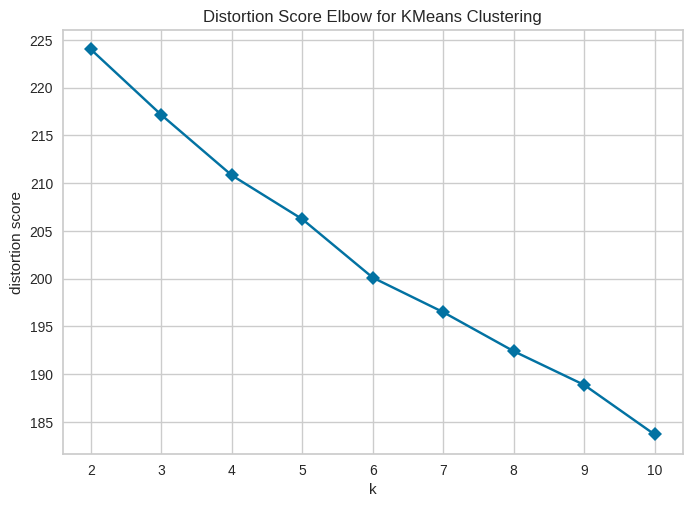

In [ ]:
plot_model(mdl_kmeans, plot = 'elbow')

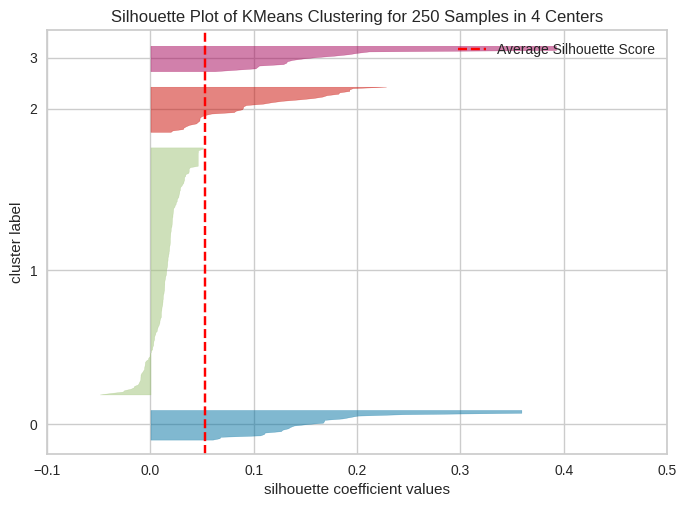

In [ ]:
plot_model(mdl_kmeans, plot = 'silhouette')

In [ ]:
plot_model(mdl_kmeans, plot = 'distribution')

In [ ]:
plot_model(mdl_kmeans, plot = 'cluster')

In [ ]:
plot_model(mdl_kmeans, plot = 'tsne')

In [ ]:
evaluate_model(mdl_kmeans)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Filmes por cluster

In [ ]:
df_processed['cluster'] = df_kmeans['Cluster']
df_processed

title_pt                     title_en  year  \
0                            Barbie                       Barbie  2023   
1             Um Sonho de Liberdade  1. The Shawshank Redemption  1994   
2                 O Poderoso Chefão             2. The Godfather  1972   
3    Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008   
4              O Poderoso Chefão II     4. The Godfather Part II  1974   
..                              ...                          ...   ...   
245              Histórias Cruzadas                246. The Help  2011   
246      Quando Duas Mulheres Pecam                 247. Persona  1966   
247                 A Vida de Brian           248. Life of Brian  1979   
248                         Aladdin                 249. Aladdin  1992   
249                   As Diabólicas              250. Diabolique  1955   

     rating     genre                                            sinopse  \
0       7.4  Aventura  viver na terra da barbie é ser um ser perfeito...   
1       9.3     Drama  dois homens presos se reúnem ao longo de vário...   
2       9.2  Policial  o patriarca idoso de uma dinastia do crime org...   
3       9.0      Ação  quando a ameaça conhecida como o coringa surge...   
4       9.0  Policial  em 1950, michael corleone, agora à frente da f...   
..      ...       ...                                                ...   
245     8.1     Drama  uma aspirante a escritora durante o movimento ...   
246     8.1     Drama  uma enfermeira é encarregada de uma atriz sile...   
247     8.0   Comédia  nascido no natal original no estábulo ao lado ...   
248     8.0  Animação  um menino de rua bondoso e um vizir competem p...   
249     8.1  Policial  a esposa e a amante de um diretor de escola de...   

     word_count                               sinopse_no_stopwords    cluster  
0            29  viver terra barbie perfeito lugar perfeito. me...  Cluster 1  
1            21  dois homens presos reúnem longo vários anos, e...  Cluster 1  
2            20  patriarca idoso dinastia crime organizado tran...  Cluster 1  
3            33  ameaça conhecida coringa surge passado, causa ...  Cluster 1  
4            41  1950, michael corleone, agora frente família, ...  Cluster 1  
..          ...                                                ...        ...  
245          32  aspirante escritora durante movimento direitos...  Cluster 1  
246          17  enfermeira encarregada atriz silenciosa descob...  Cluster 1  
247          20  nascido natal original estábulo lado jesus, br...  Cluster 0  
248          23  menino rua bondoso vizir competem lâmpada mági...  Cluster 1  
249          22  esposa amante diretor escola detestável planej...  Cluster 1  

[250 rows x 9 columns]

## % de Gêneros por Cluster

In [ ]:
fig = px.bar(df_processed.cluster.value_counts(),
             text_auto = True,
             title = 'Qtd de Filmes por Cluster',
             labels = {'index': 'Cluster #',
                       'value':'Qtd. de Filmes'})
fig.show()

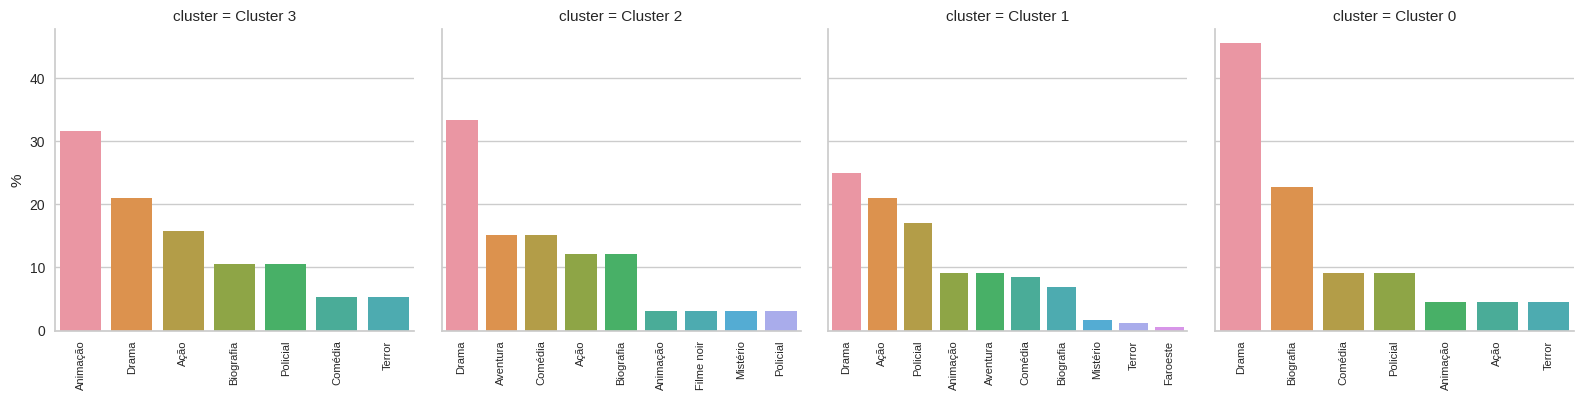

In [ ]:
df_plot = df_processed.groupby(['cluster', 'genre'])['title_pt'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'title_pt':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster', '%'], ascending = False).groupby('cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="genre", y = "%", col="cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

## Ano de Lançamento por Cluster

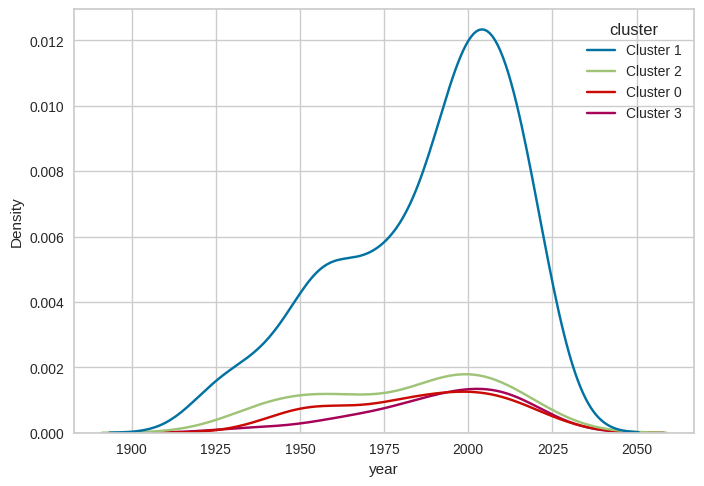

In [ ]:
sns.kdeplot(df_processed, x = 'year', hue = 'cluster');

## Radar | Gêneros por Cluster

In [ ]:
df_pivot = df_plot.copy()
df_pivot = df_pivot.pivot(index = 'cluster', columns = 'genre', values = '%')
df_pivot.fillna(0, inplace = True)
df_pivot = df_pivot.T.reset_index()
df_pivot.index.name = None
df_pivot

cluster       genre  Cluster 0  Cluster 1  Cluster 2  Cluster 3
0          Animação   4.545455   9.090909   3.030303  31.578947
1          Aventura   0.000000   9.090909  15.151515   0.000000
2              Ação   4.545455  21.022727  12.121212  15.789474
3         Biografia  22.727273   6.818182  12.121212  10.526316
4           Comédia   9.090909   8.522727  15.151515   5.263158
5             Drama  45.454545  25.000000  33.333333  21.052632
6          Faroeste   0.000000   0.568182   0.000000   0.000000
7        Filme noir   0.000000   0.000000   3.030303   0.000000
8          Mistério   0.000000   1.704545   3.030303   0.000000
9          Policial   9.090909  17.045455   3.030303  10.526316
10           Terror   4.545455   1.136364   0.000000   5.263158

In [ ]:
df_polar = df_pivot.melt(id_vars=['genre'])
df_polar.head()

genre    cluster      value
0   Animação  Cluster 0   4.545455
1   Aventura  Cluster 0   0.000000
2       Ação  Cluster 0   4.545455
3  Biografia  Cluster 0  22.727273
4    Comédia  Cluster 0   9.090909

In [ ]:
fig = px.line_polar(df_polar, r='value', theta='genre', color = 'cluster', line_close=True)
fig.show();

# Nuvem de Palavras por Cluster

# Considerações Finais
* **Exercício: Reescrever as análises / conclusões devido a atualização da base**

Cluster 1


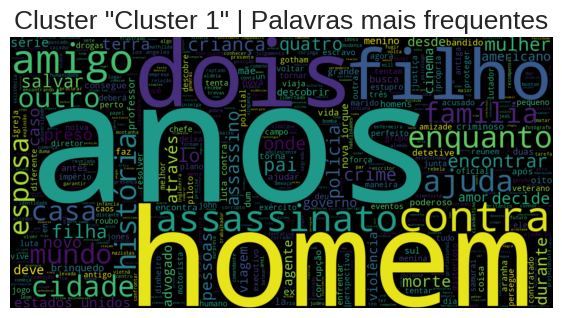

Cluster 2


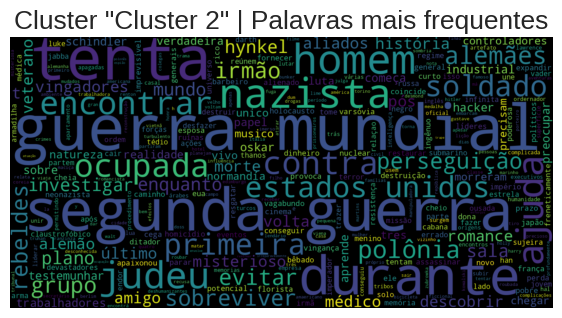

Cluster 0


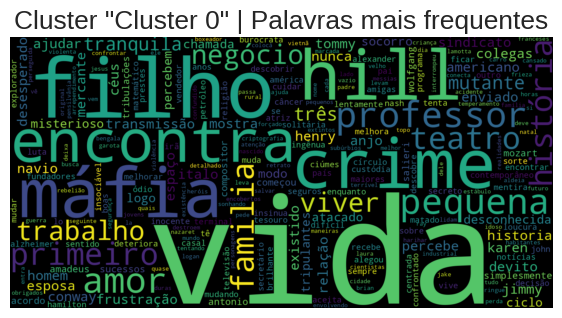

Cluster 3


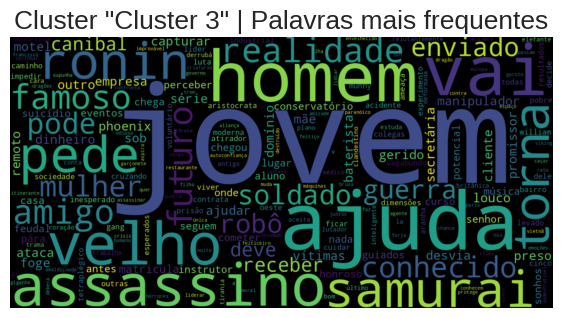

In [ ]:
def word_cloud_cluster(cluster:int):
  text = ' '.join([phrase for phrase in df_processed.loc[df_processed.cluster == cluster]['sinopse_no_stopwords']])
  plt.figure(figsize=(7,5), facecolor='None')
  wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Cluster "{cluster}" | Palavras mais frequentes', fontsize = 19)
  plt.show()
  return

list_clusters = df_processed.cluster.unique().tolist()
for c in list_clusters:
  print(c)
  word_cloud_cluster(c)

#Conclusões

In [ ]:
#Escreva aqui as suas análises / conclusões

# Adicionando demais features do df all_movies ao X

In [ ]:
pd.DataFrame(X.toarray()).shape

(250, 82)

In [ ]:
df_processed.shape

(250, 9)

In [ ]:
df_all = pd.concat([
                    df_processed.drop('cluster', axis = 1),
                    pd.DataFrame(X.toarray())
                   ]
                   , axis = 1
                   )
df_all

title_pt                     title_en  year  \
0                            Barbie                       Barbie  2023   
1             Um Sonho de Liberdade  1. The Shawshank Redemption  1994   
2                 O Poderoso Chefão             2. The Godfather  1972   
3    Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008   
4              O Poderoso Chefão II     4. The Godfather Part II  1974   
..                              ...                          ...   ...   
245              Histórias Cruzadas                246. The Help  2011   
246      Quando Duas Mulheres Pecam                 247. Persona  1966   
247                 A Vida de Brian           248. Life of Brian  1979   
248                         Aladdin                 249. Aladdin  1992   
249                   As Diabólicas              250. Diabolique  1955   

     rating     genre                                            sinopse  \
0       7.4  Aventura  viver na terra da barbie é ser um ser perfeito...   
1       9.3     Drama  dois homens presos se reúnem ao longo de vário...   
2       9.2  Policial  o patriarca idoso de uma dinastia do crime org...   
3       9.0      Ação  quando a ameaça conhecida como o coringa surge...   
4       9.0  Policial  em 1950, michael corleone, agora à frente da f...   
..      ...       ...                                                ...   
245     8.1     Drama  uma aspirante a escritora durante o movimento ...   
246     8.1     Drama  uma enfermeira é encarregada de uma atriz sile...   
247     8.0   Comédia  nascido no natal original no estábulo ao lado ...   
248     8.0  Animação  um menino de rua bondoso e um vizir competem p...   
249     8.1  Policial  a esposa e a amante de um diretor de escola de...   

     word_count                               sinopse_no_stopwords    0    1  \
0            29  viver terra barbie perfeito lugar perfeito. me...  0.0  0.0   
1            21  dois homens presos reúnem longo vários anos, e...  0.0  0.0   
2            20  patriarca idoso dinastia crime organizado tran...  0.0  0.0   
3            33  ameaça conhecida coringa surge passado, causa ...  0.0  0.0   
4            41  1950, michael corleone, agora frente família, ...  0.0  0.0   
..          ...                                                ...  ...  ...   
245          32  aspirante escritora durante movimento direitos...  0.0  0.0   
246          17  enfermeira encarregada atriz silenciosa descob...  0.0  0.0   
247          20  nascido natal original estábulo lado jesus, br...  0.0  0.0   
248          23  menino rua bondoso vizir competem lâmpada mági...  0.0  0.0   
249          22  esposa amante diretor escola detestável planej...  0.0  0.0   

     ...        72   73   74   75        76   77   78   79   80        81  
0    ...  0.707107  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.707107  
1    ...  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
2    ...  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
3    ...  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
4    ...  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
..   ...       ...  ...  ...  ...       ...  ...  ...  ...  ...       ...  
245  ...  0.000000  0.0  0.0  0.0  0.469184  0.0  0.0  0.0  0.0  0.000000  
246  ...  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
247  ...  0.000000  0.0  0.0  0.0  0.000000  0.0  1.0  0.0  0.0  0.000000  
248  ...  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
249  ...  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  

[250 rows x 90 columns]

# Setup

In [ ]:
s = setup(data = df_all,
          session_id = 123)

In [ ]:
mdl_kmeans_all = create_model('kmeans')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

# Evaluate Model

In [ ]:
evaluate_model(mdl_kmeans_all)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…